# Decode stimuli from neural activity - across multiple sessions

In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [4]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
#     r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
#     r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
#     r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
#     r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
    
]
modality = ['vis','vis','aud','vis','aud','aud']#,'vis','vis','aud','aud']
mouseIDs = ['620263','620263','620264','628801','636397','636397','644547','644547','646318','646318']
exp_nums = [1,2, 1, 1, 1,2, 1,2, 1,2]

## Loop through sessions

In [23]:
start_time=time.time()

svc_results={}

for sel_session, path in enumerate(main_path):
    svc_results[sel_session]={}
    svc_results[sel_session]['modality']=modality[sel_session]
    svc_results[sel_session]['results']={}
    
    print(path+' ... processing')
    session=Session(path=path) 
    
    ## add areas
    
    # loop through sessions and make unit xarrays
    time_before_flash = 1.5
    trial_duration = 3
    bin_size = 0.001


    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)

    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    #exclude catch trials for now
#     trial_sel=session.trials.query('trialStimID != "catch"').index
    trial_sel=session.trials.index
    
    # grab the stimulus ids
    stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)
    
    probes=session.good_units['probe'].unique()
    
    #loop through units on each probe
    for pr in probes:
        svc_results[sel_session]['results'][pr]={}
        
        unit_sel=session.good_units.query('probe == @pr').index
        
        #grab different time windows
        time_wins={}
        #1: -250:0ms
        time_wins['prestim'] = session.trial_da.sel(time=slice(-1.5,-1.25),trials=trial_sel,
                                                    unit_id=unit_sel).mean(dim='time').values
        #2: 0:250ms
        time_wins['stim_initial'] = session.trial_da.sel(time=slice(0,0.25),trials=trial_sel,
                                                         unit_id=unit_sel).mean(dim='time').values
        #3: 250:500ms
        time_wins['stim_steady'] = session.trial_da.sel(time=slice(0.25,0.5),trials=trial_sel,
                                                        unit_id=unit_sel).mean(dim='time').values
        
        #loop through different time windows
        for tw in time_wins.keys():
            X = time_wins[tw].T
            y = stim_ids
            
            #future: do manual 5-fold cross-validation
            xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)
            
            clf = svm.LinearSVC()
            clf.fit(xtrain, ytrain)
            
            ypred = clf.predict(xtest)
            
            cr_dict=classification_report(ytest, ypred, output_dict=True)
            cr_df=pd.DataFrame.from_dict(cr_dict)
            
            svc_results[sel_session]['results'][pr][tw]=cr_df
    
    elapsed_t=time.time()-start_time
    print(' ... done '+str(np.round(elapsed_t))+' sec')

\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 99.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 177.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

 ... done 267.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 372.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 444.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 517.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 651.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 750.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

 ... done 852.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 972.0 sec


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
# trial_sel

In [25]:
svc_results

{0: {'modality': 'vis',
  'results': {'B': {'prestim':                catch     sound1     sound2       vis1       vis2  accuracy  \
    precision   0.043478   0.244444   0.272727   0.200000   0.238095  0.216617   
    recall      0.080000   0.285714   0.337500   0.162162   0.123457  0.216617   
    f1-score    0.056338   0.263473   0.301676   0.179104   0.162602  0.216617   
    support    25.000000  77.000000  80.000000  74.000000  81.000000  0.216617   
    
                macro avg  weighted avg  
    precision    0.199749      0.224965  
    recall       0.197767      0.216617  
    f1-score     0.192639      0.214405  
    support    337.000000    337.000000  ,
    'stim_initial':                catch     sound1     sound2       vis1       vis2  accuracy  \
    precision   0.379310   0.418919   0.397590   0.986486   1.000000  0.667656   
    recall      0.305556   0.369048   0.515625   0.986486   0.974684  0.667656   
    f1-score    0.338462   0.392405   0.448980   0.986486   0

In [6]:
svc_results[0]['results']['B']['stim_initial']

,sound1,sound2,vis1,vis2,accuracy,macro avg,weighted avg
precision,0.613333,0.552941,1.000000,1.0,0.782468,0.791569,0.785488
recall,0.554217,0.618421,0.987500,1.0,0.782468,0.790034,0.782468
f1-score,0.582278,0.583851,0.993711,1.0,0.782468,0.789960,0.783112
support,83.000000,76.000000,80.000000,69.0,0.782468,308.000000,308.000000


In [7]:
svc_results[0]['results'].keys()

dict_keys(['B', 'C', 'F'])

0

In [10]:
# make into more plottable format

plot_results={}

timepoints=['prestim','stim_initial','stim_steady']

probes=['A','B','C','F']

for tt in timepoints:
    plot_results[tt]={}
#     plot_results[tt]['modality']=modality
    for pr in probes:
        plot_results[tt][pr+'_vis']=[]
        plot_results[tt][pr+'_aud']=[]

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]
for tt in timepoints:
    for ss in range(0,len(svc_results)):
        
        for pr in probes: #svc_results[ss]['results'].keys():
            if pr in svc_results[ss]['results'].keys():
                vis_perf=(
                    np.sum([svc_results[ss]['results'][pr][tt]['vis1'][['precision','recall']].values,
                            svc_results[ss]['results'][pr][tt]['vis2'][['precision','recall']].values]))/4

                aud_perf=(
                    np.sum([svc_results[ss]['results'][pr][tt]['sound1'][['precision','recall']].values,
                            svc_results[ss]['results'][pr][tt]['sound2'][['precision','recall']].values]))/4


                plot_results[tt][pr+'_vis'].append(vis_perf)
                plot_results[tt][pr+'_aud'].append(aud_perf)
            
            else:
                plot_results[tt][pr+'_vis'].append(np.nan)
                plot_results[tt][pr+'_aud'].append(np.nan)

    plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [11]:
plot_results['stim_initial']

,A_vis,A_aud,B_vis,B_aud,C_vis,C_aud,F_vis,F_aud
0,NaN,NaN,0.996875,0.584728,1.000000,1.000000,0.996094,0.679180
1,0.832404,0.482044,0.965890,0.700144,0.985922,0.938911,0.968798,0.560633
2,0.504735,0.854620,0.996711,0.808112,0.642420,0.967525,0.500417,0.861971
3,0.919917,0.585004,1.000000,0.990738,0.833397,1.000000,0.957647,0.564958
4,0.769794,0.833153,0.793699,0.893831,0.491264,0.858763,0.572736,0.832305
5,0.776715,0.768015,0.308177,0.517447,0.553992,0.982453,0.767873,0.913544
6,0.964478,0.607443,0.990386,0.514677,0.996753,0.875508,0.931710,0.486319
7,0.933892,0.517003,0.993333,0.453248,0.993777,0.978220,0.911195,0.469512
8,0.396420,0.369022,0.954574,0.507802,0.799312,0.941207,0.657886,0.740798
9,0.724837,0.869248,0.787647,0.875671,0.857843,0.993304,0.463785,0.876790


<IPython.core.display.Javascript object>


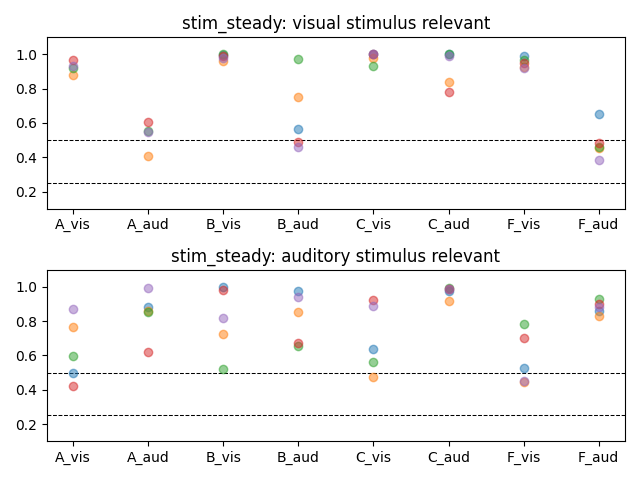

In [19]:
set_timepoint='stim_steady'

fig,ax=plt.subplots(2,1)
ax[0].axhline(0.25,color='k',linewidth=0.75,linestyle='--')
ax[0].axhline(0.5,color='k',linewidth=0.75,linestyle='--')
ax[0].plot(plot_results[set_timepoint][np.asarray(modality[:])=='vis'].values.T,'o',alpha=0.5)
ax[0].set_xticks(np.arange(0,8))
ax[0].set_xticklabels(plot_results[set_timepoint].columns)
ax[0].set_title(set_timepoint+': visual stimulus relevant')
ax[0].set_ylim([0.1,1.1])

ax[1].axhline(0.25,color='k',linewidth=0.75,linestyle='--')
ax[1].axhline(0.5,color='k',linewidth=0.75,linestyle='--')
ax[1].plot(plot_results[set_timepoint][np.asarray(modality[:])=='aud'].values.T,'o',alpha=0.5)
ax[1].set_xticks(np.arange(0,8))
ax[1].set_xticklabels(plot_results[set_timepoint].columns)
ax[1].set_title(set_timepoint+': auditory stimulus relevant')
ax[1].set_ylim([0.1,1.1])

fig.tight_layout()

In [ ]:
plot_results['stim_initial'][np.asarray(modality) == 'vis']